In [1]:
# Notebook: Answers to Question 4
# Author: Ben Bernal
# Date: 29JUL2024

### Preliminaries

#### Libraries

In [56]:
import numpy as np
import pandas as pd
from os import path, listdir
from pprint import pprint
import re
import plotly.express as px
import plotly.graph_objects as go
from dataclasses import make_dataclass
from icecream import ic
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#### Utilities

In [3]:
from utilities import json as util_json

#### Configuration

In [4]:
env_config = util_json.to_dict(
    file_path="../../config/env.json"
)

# Dataset

## Pre-processing

In [5]:
raw_frame = pd.read_csv(
    path.normpath(
        path.join(
            env_config['root'],
            "modules/m4/release_time_series_report_data_nops/CPI.csv"
        )
    )
)

print(raw_frame.head(3).to_markdown(tablefmt="grid"))

+----+-----------+-------+
|    | date      |   CPI |
+====+===========+=======+
|  0 | 7/24/2008 |   100 |
+----+-----------+-------+
|  1 | 7/25/2008 |   100 |
+----+-----------+-------+
|  2 | 7/26/2008 |   100 |
+----+-----------+-------+


In [37]:
frame = (
    raw_frame
    .assign(
        date_time_frmt = lambda X: pd.to_datetime(
                                        arg=X.date
                                    )
    )
    .set_index(
        keys='date_time_frmt',
        drop=False
    )    
    .assign(
        month = lambda X:  X.index.month
    )
    .dropna(
        subset=[
            'date',
            'CPI',
        ],
        how='any'
    )
)


print(frame.head(20).to_markdown(tablefmt="grid"))

+---------------------+-----------+---------+---------------------+---------+
| date_time_frmt      | date      |     CPI | date_time_frmt      |   month |
+=====================+===========+=========+=====================+=========+
| 2008-07-24 00:00:00 | 7/24/2008 | 100     | 2008-07-24 00:00:00 |       7 |
+---------------------+-----------+---------+---------------------+---------+
| 2008-07-25 00:00:00 | 7/25/2008 | 100     | 2008-07-25 00:00:00 |       7 |
+---------------------+-----------+---------+---------------------+---------+
| 2008-07-26 00:00:00 | 7/26/2008 | 100     | 2008-07-26 00:00:00 |       7 |
+---------------------+-----------+---------+---------------------+---------+
| 2008-07-27 00:00:00 | 7/27/2008 | 100     | 2008-07-27 00:00:00 |       7 |
+---------------------+-----------+---------+---------------------+---------+
| 2008-07-28 00:00:00 | 7/28/2008 | 100     | 2008-07-28 00:00:00 |       7 |
+---------------------+-----------+---------+-------------------

In [42]:
cpi_monthly_frame = (
    frame
    .resample(
        rule="MS",
        on = "date_time_frmt"
    )[
        'CPI'
    ]
    .agg(
        [
            'first'
        ]
    )
    .assign(
        month_idx = lambda X:  [i for i in range(X.shape[0])]
    )
)

print(
    cpi_monthly_frame.head().to_markdown(
        tablefmt='grid'
    )
    )

+---------------------+----------+-------------+
| date_time_frmt      |    first |   month_idx |
+=====================+==========+=============+
| 2008-07-01 00:00:00 | 100      |           0 |
+---------------------+----------+-------------+
| 2008-08-01 00:00:00 | 100.525  |           1 |
+---------------------+----------+-------------+
| 2008-09-01 00:00:00 | 100.124  |           2 |
+---------------------+----------+-------------+
| 2008-10-01 00:00:00 |  99.9854 |           3 |
+---------------------+----------+-------------+
| 2008-11-01 00:00:00 |  98.9754 |           4 |
+---------------------+----------+-------------+


## Train Test Split

In [43]:
train_frame = frame.loc[:'2013-08-31']

print(
    train_frame.tail().to_markdown(tablefmt='grid')
)

+---------------------+-----------+---------+---------------------+---------+
| date_time_frmt      | date      |     CPI | date_time_frmt      |   month |
+=====================+===========+=========+=====================+=========+
| 2013-08-27 00:00:00 | 8/27/2013 | 106.755 | 2013-08-27 00:00:00 |       8 |
+---------------------+-----------+---------+---------------------+---------+
| 2013-08-28 00:00:00 | 8/28/2013 | 106.755 | 2013-08-28 00:00:00 |       8 |
+---------------------+-----------+---------+---------------------+---------+
| 2013-08-29 00:00:00 | 8/29/2013 | 106.755 | 2013-08-29 00:00:00 |       8 |
+---------------------+-----------+---------+---------------------+---------+
| 2013-08-30 00:00:00 | 8/30/2013 | 106.755 | 2013-08-30 00:00:00 |       8 |
+---------------------+-----------+---------+---------------------+---------+
| 2013-08-31 00:00:00 | 8/31/2013 | 106.755 | 2013-08-31 00:00:00 |       8 |
+---------------------+-----------+---------+-------------------

In [44]:
test_frame = frame.loc['2013-09-01':]

print(
    test_frame.head().to_markdown(tablefmt='grid')
)

+---------------------+----------+---------+---------------------+---------+
| date_time_frmt      | date     |     CPI | date_time_frmt      |   month |
+=====================+==========+=========+=====================+=========+
| 2013-09-01 00:00:00 | 9/1/2013 | 106.883 | 2013-09-01 00:00:00 |       9 |
+---------------------+----------+---------+---------------------+---------+
| 2013-09-02 00:00:00 | 9/2/2013 | 106.883 | 2013-09-02 00:00:00 |       9 |
+---------------------+----------+---------+---------------------+---------+
| 2013-09-03 00:00:00 | 9/3/2013 | 106.883 | 2013-09-03 00:00:00 |       9 |
+---------------------+----------+---------+---------------------+---------+
| 2013-09-04 00:00:00 | 9/4/2013 | 106.883 | 2013-09-04 00:00:00 |       9 |
+---------------------+----------+---------+---------------------+---------+
| 2013-09-05 00:00:00 | 9/5/2013 | 106.883 | 2013-09-05 00:00:00 |       9 |
+---------------------+----------+---------+---------------------+---------+

# Manipulations

## Trend

In [45]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['first'],
        name='Monthly CPI Trend',
        mode="markers+lines"
    )
)
fig.show()

## Linear Projection

In [48]:
reg = LinearRegression().fit(
    X = cpi_monthly_frame.loc[:"2013-08-31"][['month_idx']],
    y=cpi_monthly_frame.loc[:"2013-08-31"][['first']]
)

In [50]:
cpi_monthly_frame['cpi_linear_model'] = None
cpi_monthly_frame.loc[:"2013-08-31", 'cpi_linear_model'] = reg.predict(
    X=cpi_monthly_frame.loc[:"2013-08-31"][['month_idx']]
)
cpi_monthly_frame.loc["2013-09-01":,'cpi_linear_model'] = reg.predict(
    X=cpi_monthly_frame.loc["2013-09-01":][['month_idx']]
)

In [51]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['first'],
        name='Monthly CPI Trend',
        mode="markers+lines"
    )
)
fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['cpi_linear_model'],
        name='CPI Linear Model',
        mode="markers+lines"
    )
)
fig.show()

In [52]:
ic(reg.coef_)
ic(reg.intercept_)

ic| reg.coef_: array([[0.16104348]])
ic| reg.intercept_: array([96.72932633])


array([96.72932633])

In [53]:
cpi_monthly_frame['residuals_linear_model'] = cpi_monthly_frame['first'] - cpi_monthly_frame['cpi_linear_model']

In [54]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = cpi_monthly_frame.index,
        y = cpi_monthly_frame['residuals_linear_model'],
        name='Residuals',
        mode="markers"
    )
)

fig.show()

In [55]:
max(cpi_monthly_frame.loc[:'2013-08-31','residuals_linear_model'])

3.634730187605456

## Auto Correlation

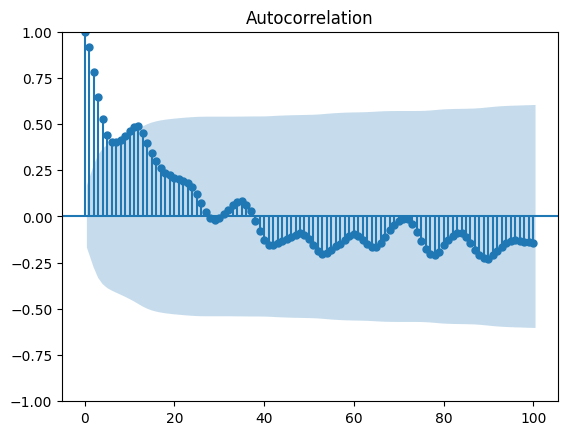

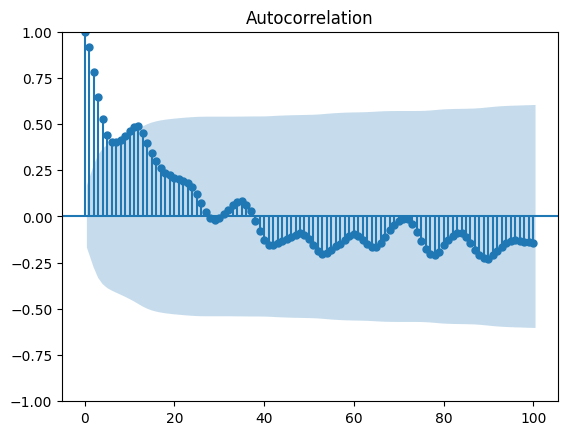

In [61]:
plot_acf(
    x = cpi_monthly_frame[
        [
            'residuals_linear_model'
        ]
    ],
    lags = 100
)

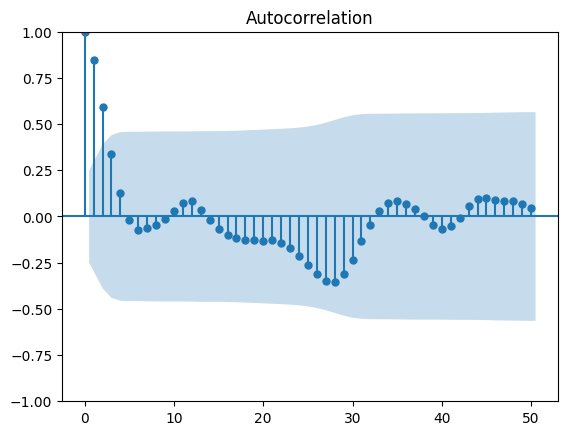

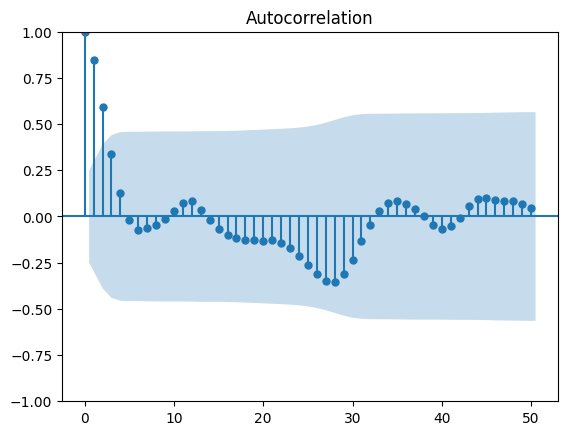

In [75]:
plot_acf(
    x = cpi_monthly_frame[['residuals_linear_model']].loc[:'2013-08-31'],
    lags = 50
)

In [72]:
cpi_monthly_frame[['residuals_linear_model']].loc[:'2013-08-31']

,residuals_linear_model
date_time_frmt,
2008-07-01,3.270674
2008-08-01,3.63473
2008-09-01,3.072387
2008-10-01,2.772923
2008-11-01,1.60189
...,...
2013-04-01,0.470095
2013-05-01,0.198452
2013-06-01,0.226608


In [65]:
cpi_monthly_frame.loc[:'2013-08-31', ['residuals_linear_model']]

,residuals_linear_model
date_time_frmt,
2008-07-01,3.270674
2008-08-01,3.63473
2008-09-01,3.072387
2008-10-01,2.772923
2008-11-01,1.60189
...,...
2013-04-01,0.470095
2013-05-01,0.198452
2013-06-01,0.226608
